# Cohort Analyses

## References

|Link|Notes|
|---|---|
|https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html|Basic spread models|
|https://www.insidermonkey.com/blog/donald-trump-has-3-3-percent-chance-of-dying-from-coronavirus-817781/|Basic risk mdoel|

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from ipypb import track
import datetime as dt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from celluloid import Camera
import os

In [2]:
pd.options.display.max_columns = 999

## Data

Data Sources (keep it simple and focus on building the models)
- https://covidtracking.com/api/
- New York Times

In [3]:
nytCountyData = "C:\\Users\\garfink2\\Documents\\data\\covid\\covid-19-data\\us-counties.csv"
folderOfJHUData = "C:\\Users\\garfink2\\Documents\\data\\covid\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
shp_USStates = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_state\\tl_2017_us_state.shp"
excel_CountyPopulations = "C:\\Users\\garfink2\\Documents\\data\\basemap\\co-est2019-alldata.xlsx"

In [150]:
df_nytCountyData = pd.read_csv(nytCountyData)
gdf_USCounties = gpd.read_file(shp_USCounties)
gdf_USStates = gpd.read_file(shp_USStates)

In [151]:
df_countyPouplations = pd.read_excel(excel_CountyPopulations)

## Add in population data to counties

In [152]:
fips = []
for i,row in df_countyPouplations.iterrows():
    fip = int(f"{row['STATE']}{str(row['COUNTY']).zfill(3)}")
    fips.append(fip)
df_countyPouplations["fips"] = fips

In [153]:
df_countyPouplations["fips"]

0        1000
1        1001
2        1003
3        1005
4        1007
        ...  
3188    56037
3189    56039
3190    56041
3191    56043
3192    56045
Name: fips, Length: 3193, dtype: int64

In [154]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry"]]

In [155]:
gdf_USCounties["GEOID"] = gdf_USCounties["GEOID"].astype("int")

In [156]:
len(fips)

3193

In [157]:
len(list(gdf_USCounties["GEOID"]))

3233

In [158]:
gdf_USCounties.sort_values("GEOID").head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry
1328,01,001,1001,Autauga,Autauga County,"POLYGON ((-86.90310 32.54063, -86.90311 32.540..."
1246,01,003,1003,Baldwin,Baldwin County,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
1827,01,005,1005,Barbour,Barbour County,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
3014,01,007,1007,Bibb,Bibb County,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
855,01,009,1009,Blount,Blount County,"POLYGON ((-86.74919 33.99760, -86.74902 33.997..."


In [159]:
gdf_USCounties = pd.merge(left=gdf_USCounties,right=df_countyPouplations,left_on="GEOID",right_on="fips")

In [160]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry","POPESTIMATE2019"]]

In [161]:
len(df_countyPouplations)

3193

In [162]:
len(gdf_USCounties)

3142

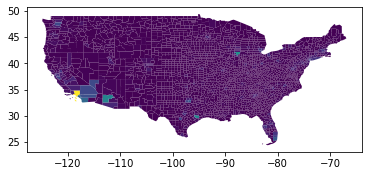

In [163]:
gdf_USCounties.cx[-125:-50, 20:70].plot("POPESTIMATE2019")

## Load the NYT Data

In [164]:
# KLUDGE- create custom fips for New York City and Kansas City

In [165]:
df_nytCountyData.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [166]:
df_nytCountyData.loc[(df_nytCountyData.county=="New York City"),"fips"]=36047

In [167]:
df_nytCountyData.loc[(df_nytCountyData.county=="Kansas City"),"fips"]=29095

In [168]:
df_nytCountyData = df_nytCountyData.dropna(subset=["fips"])

In [169]:
df_nytCountyData["fips"] = df_nytCountyData["fips"].astype("int")

In [170]:
df_nytCountyData.sort_values("deaths",ascending=False)

,date,county,state,fips,cases,deaths
37185,2020-04-06,New York City,New York,36047,68776,2738
34709,2020-04-05,New York City,New York,36047,67552,2472
32273,2020-04-04,New York City,New York,36047,63307,2254
29882,2020-04-03,New York City,New York,36047,57160,1867
27559,2020-04-02,New York City,New York,36047,51810,1562
...,...,...,...,...,...,...
13178,2020-03-26,Humphreys,Mississippi,28053,1,0
13176,2020-03-26,Hinds,Mississippi,28049,43,0
13175,2020-03-26,Harrison,Mississippi,28047,31,0
13173,2020-03-26,Grenada,Mississippi,28043,2,0


In [171]:
gdf_countyTimeSeries = gpd.GeoDataFrame(pd.merge(left=df_nytCountyData,right=gdf_USCounties,left_on="fips",right_on="GEOID"))

In [172]:
gdf_countyTimeSeries['date'] = pd.to_datetime(gdf_countyTimeSeries['date'], errors='coerce')

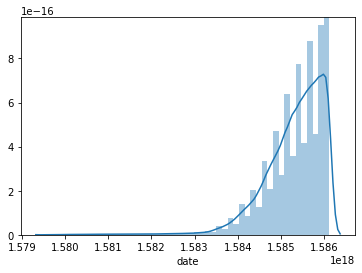

In [173]:
sns.distplot(gdf_countyTimeSeries["date"])

In [174]:
gpd.GeoDataFrame(gdf_countyTimeSeries[gdf_countyTimeSeries["fips"]==53061]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
date,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00
county,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish
state,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington
fips,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061
cases,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,5,8,17,18,26,36,45,61,69,107,132,154,175,199,2

In [175]:
gdf_countyTimeSeriesDiff = gdf_countyTimeSeries.copy(deep=True)

In [176]:
gdf_countyTimeSeriesDiff["new cases"] = gdf_countyTimeSeriesDiff.groupby("fips")[["cases"]].diff().fillna(0)

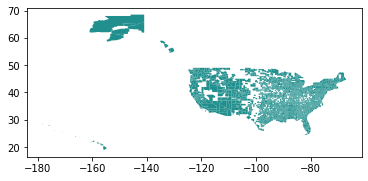

In [180]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["date"] == dt.datetime(month=4,day=6,year=2020)].plot("new cases")

Convert NYT data to date cases and date deaths

In [25]:
allFIPS = list(set(gdf_countyTimeSeries["fips"]))
dts = list(set(gdf_countyTimeSeries["date"]))
dts.sort()

In [26]:
dict_NYTData = {"fips":[]}
for dti in dts:
    columnNameBase = dti.strftime("%Y-%m-%d")
    casesColumn = f"{columnNameBase} Cumulative Cases"
    deathsColumn = f"{columnNameBase} Cumulative Deaths"
    newCasesColumn = f"{columnNameBase} Cases"
    newDeathsColumn = f"{columnNameBase} Deaths"
    dict_NYTData[casesColumn] = []
    dict_NYTData[deathsColumn] = []
    dict_NYTData[newCasesColumn] = 0
    dict_NYTData[newDeathsColumn] = 0

In [27]:
for fips in allFIPS:
    dict_NYTData["fips"].append(fips)
    for dti in dts:
        columnNameBase = dti.strftime("%Y-%m-%d")
        casesColumn = f"{columnNameBase} Cumulative Cases"
        deathsColumn = f"{columnNameBase} Cumulative Deaths"
        cases = 0
        deaths = 0
        try:
            relevantColumn = gdf_countyTimeSeries[(gdf_countyTimeSeries["fips"]==fips) & (gdf_countyTimeSeries["date"]==dti)]
            cases = relevantColumn["cases"].iloc[0]
            deaths = relevantColumn["deaths"].iloc[0]
        except:
            cases = 0
            deaths = 0
        dict_NYTData[casesColumn].append(cases)
        dict_NYTData[deathsColumn].append(deaths)

In [28]:
df_NYTData = pd.DataFrame(dict_NYTData)

In [29]:
df_NYTData.head()

,fips,2020-01-21 Cumulative Cases,2020-01-21 Cumulative Deaths,2020-01-21 Cases,2020-01-21 Deaths,2020-01-22 Cumulative Cases,2020-01-22 Cumulative Deaths,2020-01-22 Cases,2020-01-22 Deaths,2020-01-23 Cumulative Cases,2020-01-23 Cumulative Deaths,2020-01-23 Cases,2020-01-23 Deaths,2020-01-24 Cumulative Cases,2020-01-24 Cumulative Deaths,2020-01-24 Cases,2020-01-24 Deaths,2020-01-25 Cumulative Cases,2020-01-25 Cumulative Deaths,2020-01-25 Cases,2020-01-25 Deaths,2020-01-26 Cumulative Cases,2020-01-26 Cumulative Deaths,2020-01-26 Cases,2020-01-26 Deaths,2020-01-27 Cumulative Cases,2020-01-27 Cumulative Deaths,2020-01-27 Cases,2020-01-27 Deaths,2020-01-28 Cumulative Cases,2020-01-28 Cumulative Deaths,2020-01-28 Cases,2020-01-28 Deaths,2020-01-29 Cumulative Cases,2020-01-29 Cumulative Deaths,2020-01-29 Cases,2020-01-29 Deaths,2020-01-30 Cumulative Cases,2020-01-30 Cumulative Deaths,2020-01-30 Cases,2020-01-30 Deaths,2020-01-31 Cumulative Cases,2020-01-31 Cumulative Deaths,2020-01-31 Cases,2020-01-31 Deaths,2020-02-01 Cumulative Cases,2020-02-01 Cumulative Deaths,2020-02-01 Cases,2020-02-01 Deaths,2020-02-02 Cumulative Cases,2020-02-02 Cumulative Deaths,2020-02-02 Cases,2020-02-02 Deaths,2020-02-03 Cumulative Cases,2020-02-03 Cumulative Deaths,2020-02-03 Cases,2020-02-03 Deaths,2020-02-04 Cumulative Cases,2020-02-04 Cumulative Deaths,2020-02-04 Cases,2020-02-04 Deaths,2020-02-05 Cumulative Cases,2020-02-05 Cumulative Deaths,2020-02-05 Cases,2020-02-05 Deaths,2020-02-06 Cumulative Cases,2020-02-06 Cumulative Deaths,2020-02-06 Cases,2020-02-06 Deaths,2020-02-07 Cumulative Cases,2020-02-07 Cumulative Deaths,2020-02-07 Cases,2020-02-07 Deaths,2020-02-08 Cumulative Cases,2020-02-08 Cumulative Deaths,2020-02-08 Cases,2020-02-08 Deaths,2020-02-09 Cumulative Cases,2020-02-09 Cumulative Deaths,2020-02-09 Cases,2020-02-09 Deaths,2020-02-10 Cumulative Cases,2020-02-10 Cumulative Deaths,2020-02-10 Cases,2020-02-10 Deaths,2020-02-11 Cumulative Cases,2020-02-11 Cumulative Deaths,2020-02-11 Cases,2020-02-11 Deaths,2020-02-12 Cumulative Cases,2020-02-12 Cumulative Deaths,2020-02-12 Cases,2020-02-12 Deaths,2020-02-13 Cumulative Cases,2020-02-13 Cumulative Deaths,2020-02-13 Cases,2020-02-13 Deaths,2020-02-14 Cumulative Cases,2020-02-14 Cumulative Deaths,2020-02-14 Cases,2020-02-14 Deaths,2020-02-15 Cumulative Cases,2020-02-15 Cumulative Deaths,2020-02-15 Cases,2020-02-15 Deaths,2020-02-16 Cumulative Cases,2020-02-16 Cumulative Deaths,2020-02-16 Cases,2020-02-16 Deaths,2020-02-17 Cumulative Cases,2020-02-17 Cumulative Deaths,2020-02-17 Cases,2020-02-17 Deaths,2020-02-18 Cumulative Cases,2020-02-18 Cumulative Deaths,2020-02-18 Cases,2020-02-18 Deaths,2020-02-19 Cumulative Cases,2020-02-19 Cumulative Deaths,2020-02-19 Cases,2020-02-19 Deaths,2020-02-20 Cumulative Cases,2020-02-20 Cumulative Deaths,2020-02-20 Cases,2020-02-20 Deaths,2020-02-21 Cumulative Cases,2020-02-21 Cumulative Deaths,2020-02-21 Cases,2020-02-21 Deaths,2020-02-22 Cumulative Cases,2020-02-22 Cumulative Deaths,2020-02-22 Cases,2020-02-22 Deaths,2020-02-23 Cumulative Cases,2020-02-23 Cumulative Deaths,2020-02-23 Cases,2020-02-23 Deaths,2020-02-24 Cumulative Cases,2020-02-24 Cumulative Deaths,2020-02-24 Cases,2020-02-24 Deaths,2020-02-25 Cumulative Cases,2020-02-25 Cumulative Deaths,2020-02-25 Cases,2020-02-25 Deaths,2020-02-26 Cumulative Cases,2020-02-26 Cumulative Deaths,2020-02-26 Cases,2020-02-26 Deaths,2020-02-27 Cumulative Cases,2020-02-27 Cumulative Deaths,2020-02-27 Cases,2020-02-27 Deaths,2020-02-28 Cumulative Cases,2020-02-28 Cumulative Deaths,2020-02-28 Cases,2020-02-28 Deaths,2020-02-29 Cumulative Cases,2020-02-29 Cumulative Deaths,2020-02-29 Cases,2020-02-29 Deaths,2020-03-01 Cumulative Cases,2020-03-01 Cumulative Deaths,2020-03-01 Cases,2020-03-01 Deaths,2020-03-02 Cumulative Cases,2020-03-02 Cumulative Deaths,2020-03-02 Cases,2020-03-02 Deaths,2020-03-03 Cumulative Cases,2020-03-03 Cumulative Deaths,2020-03-03 Cases,2020-03-03 Deaths,2020-03-04 Cumulative Cases,2020-03-04

In [30]:
gdf_NYTTimeSeries = gpd.GeoDataFrame(pd.merge(left=df_NYTData,right=gdf_USCounties,left_on="fips",right_on="GEOID"))

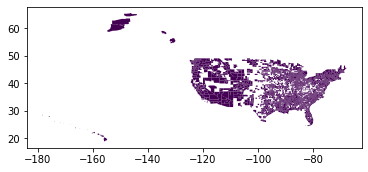

In [31]:
gdf_NYTTimeSeries.plot("2020-03-31 Deaths")

Convert to daily adds

In [32]:
dts.sort(reverse=False)

In [33]:
gdf_NYTTimeSeries_NewCases = gdf_NYTTimeSeries.copy(deep=True)

In [34]:
for i,dti in enumerate(dts):
    columnNameBase = dti.strftime("%Y-%m-%d")
    casesColumn = f"{columnNameBase} Cases"
    deathsColumn = f"{columnNameBase} Deaths"
    cumulativeCasesColumn = f"{columnNameBase} Cumulative Cases"
    cumulativeDeathsColumn = f"{columnNameBase} Cumulative Deaths"
    if i == 0:
        gdf_NYTTimeSeries_NewCases[casesColumn] = gdf_NYTTimeSeries_NewCases[cumulativeCasesColumn] 
        gdf_NYTTimeSeries_NewCases[deathsColumn] = gdf_NYTTimeSeries_NewCases[cumulativeDeathsColumn] 
    else:
        previousColumnBaseName = dts[i-1].strftime("%Y-%m-%d")
        previousCasesColumn = f"{previousColumnBaseName} Cumulative Cases"
        previousDeathsColumn = f"{previousColumnBaseName} Cumulative Deaths"
        gdf_NYTTimeSeries_NewCases[casesColumn] = gdf_NYTTimeSeries_NewCases[cumulativeCasesColumn] - gdf_NYTTimeSeries_NewCases[previousCasesColumn]
        gdf_NYTTimeSeries_NewCases[deathsColumn] = gdf_NYTTimeSeries_NewCases[cumulativeDeathsColumn] - gdf_NYTTimeSeries_NewCases[previousDeathsColumn]

In [35]:
gdf_NYTTimeSeries_NewCases[gdf_NYTTimeSeries_NewCases["NAME"]=="Kings"]

,fips,2020-01-21 Cumulative Cases,2020-01-21 Cumulative Deaths,2020-01-21 Cases,2020-01-21 Deaths,2020-01-22 Cumulative Cases,2020-01-22 Cumulative Deaths,2020-01-22 Cases,2020-01-22 Deaths,2020-01-23 Cumulative Cases,2020-01-23 Cumulative Deaths,2020-01-23 Cases,2020-01-23 Deaths,2020-01-24 Cumulative Cases,2020-01-24 Cumulative Deaths,2020-01-24 Cases,2020-01-24 Deaths,2020-01-25 Cumulative Cases,2020-01-25 Cumulative Deaths,2020-01-25 Cases,2020-01-25 Deaths,2020-01-26 Cumulative Cases,2020-01-26 Cumulative Deaths,2020-01-26 Cases,2020-01-26 Deaths,2020-01-27 Cumulative Cases,2020-01-27 Cumulative Deaths,2020-01-27 Cases,2020-01-27 Deaths,2020-01-28 Cumulative Cases,2020-01-28 Cumulative Deaths,2020-01-28 Cases,2020-01-28 Deaths,2020-01-29 Cumulative Cases,2020-01-29 Cumulative Deaths,2020-01-29 Cases,2020-01-29 Deaths,2020-01-30 Cumulative Cases,2020-01-30 Cumulative Deaths,2020-01-30 Cases,2020-01-30 Deaths,2020-01-31 Cumulative Cases,2020-01-31 Cumulative Deaths,2020-01-31 Cases,2020-01-31 Deaths,2020-02-01 Cumulative Cases,2020-02-01 Cumulative Deaths,2020-02-01 Cases,2020-02-01 Deaths,2020-02-02 Cumulative Cases,2020-02-02 Cumulative Deaths,2020-02-02 Cases,2020-02-02 Deaths,2020-02-03 Cumulative Cases,2020-02-03 Cumulative Deaths,2020-02-03 Cases,2020-02-03 Deaths,2020-02-04 Cumulative Cases,2020-02-04 Cumulative Deaths,2020-02-04 Cases,2020-02-04 Deaths,2020-02-05 Cumulative Cases,2020-02-05 Cumulative Deaths,2020-02-05 Cases,2020-02-05 Deaths,2020-02-06 Cumulative Cases,2020-02-06 Cumulative Deaths,2020-02-06 Cases,2020-02-06 Deaths,2020-02-07 Cumulative Cases,2020-02-07 Cumulative Deaths,2020-02-07 Cases,2020-02-07 Deaths,2020-02-08 Cumulative Cases,2020-02-08 Cumulative Deaths,2020-02-08 Cases,2020-02-08 Deaths,2020-02-09 Cumulative Cases,2020-02-09 Cumulative Deaths,2020-02-09 Cases,2020-02-09 Deaths,2020-02-10 Cumulative Cases,2020-02-10 Cumulative Deaths,2020-02-10 Cases,2020-02-10 Deaths,2020-02-11 Cumulative Cases,2020-02-11 Cumulative Deaths,2020-02-11 Cases,2020-02-11 Deaths,2020-02-12 Cumulative Cases,2020-02-12 Cumulative Deaths,2020-02-12 Cases,2020-02-12 Deaths,2020-02-13 Cumulative Cases,2020-02-13 Cumulative Deaths,2020-02-13 Cases,2020-02-13 Deaths,2020-02-14 Cumulative Cases,2020-02-14 Cumulative Deaths,2020-02-14 Cases,2020-02-14 Deaths,2020-02-15 Cumulative Cases,2020-02-15 Cumulative Deaths,2020-02-15 Cases,2020-02-15 Deaths,2020-02-16 Cumulative Cases,2020-02-16 Cumulative Deaths,2020-02-16 Cases,2020-02-16 Deaths,2020-02-17 Cumulative Cases,2020-02-17 Cumulative Deaths,2020-02-17 Cases,2020-02-17 Deaths,2020-02-18 Cumulative Cases,2020-02-18 Cumulative Deaths,2020-02-18 Cases,2020-02-18 Deaths,2020-02-19 Cumulative Cases,2020-02-19 Cumulative Deaths,2020-02-19 Cases,2020-02-19 Deaths,2020-02-20 Cumulative Cases,2020-02-20 Cumulative Deaths,2020-02-20 Cases,2020-02-20 Deaths,2020-02-21 Cumulative Cases,2020-02-21 Cumulative Deaths,2020-02-21 Cases,2020-02-21 Deaths,2020-02-22 Cumulative Cases,2020-02-22 Cumulative Deaths,2020-02-22 Cases,2020-02-22 Deaths,2020-02-23 Cumulative Cases,2020-02-23 Cumulative Deaths,2020-02-23 Cases,2020-02-23 Deaths,2020-02-24 Cumulative Cases,2020-02-24 Cumulative Deaths,2020-02-24 Cases,2020-02-24 Deaths,2020-02-25 Cumulative Cases,2020-02-25 Cumulative Deaths,2020-02-25 Cases,2020-02-25 Deaths,2020-02-26 Cumulative Cases,2020-02-26 Cumulative Deaths,2020-02-26 Cases,2020-02-26 Deaths,2020-02-27 Cumulative Cases,2020-02-27 Cumulative Deaths,2020-02-27 Cases,2020-02-27 Deaths,2020-02-28 Cumulative Cases,2020-02-28 Cumulative Deaths,2020-02-28 Cases,2020-02-28 Deaths,2020-02-29 Cumulative Cases,2020-02-29 Cumulative Deaths,2020-02-29 Cases,2020-02-29 Deaths,2020-03-01 Cumulative Cases,2020-03-01 Cumulative Deaths,2020-03-01 Cases,2020-03-01 Deaths,2020-03-02 Cumulative Cases,2020-03-02 Cumulative Deaths,2020-03-02 Cases,2020-03-02 Deaths,2020-03-03 Cumulative Cases,2020-03-03 Cumulative Deaths,2020-03-03 Cases,2020-03-03 Deaths,2020-03-04 Cumulative Cases,2020-03-04

In [36]:
gdf_NYTTimeSeries_NewCases.cx[--80:-70, 40:50].head(10)

,fips,2020-01-21 Cumulative Cases,2020-01-21 Cumulative Deaths,2020-01-21 Cases,2020-01-21 Deaths,2020-01-22 Cumulative Cases,2020-01-22 Cumulative Deaths,2020-01-22 Cases,2020-01-22 Deaths,2020-01-23 Cumulative Cases,2020-01-23 Cumulative Deaths,2020-01-23 Cases,2020-01-23 Deaths,2020-01-24 Cumulative Cases,2020-01-24 Cumulative Deaths,2020-01-24 Cases,2020-01-24 Deaths,2020-01-25 Cumulative Cases,2020-01-25 Cumulative Deaths,2020-01-25 Cases,2020-01-25 Deaths,2020-01-26 Cumulative Cases,2020-01-26 Cumulative Deaths,2020-01-26 Cases,2020-01-26 Deaths,2020-01-27 Cumulative Cases,2020-01-27 Cumulative Deaths,2020-01-27 Cases,2020-01-27 Deaths,2020-01-28 Cumulative Cases,2020-01-28 Cumulative Deaths,2020-01-28 Cases,2020-01-28 Deaths,2020-01-29 Cumulative Cases,2020-01-29 Cumulative Deaths,2020-01-29 Cases,2020-01-29 Deaths,2020-01-30 Cumulative Cases,2020-01-30 Cumulative Deaths,2020-01-30 Cases,2020-01-30 Deaths,2020-01-31 Cumulative Cases,2020-01-31 Cumulative Deaths,2020-01-31 Cases,2020-01-31 Deaths,2020-02-01 Cumulative Cases,2020-02-01 Cumulative Deaths,2020-02-01 Cases,2020-02-01 Deaths,2020-02-02 Cumulative Cases,2020-02-02 Cumulative Deaths,2020-02-02 Cases,2020-02-02 Deaths,2020-02-03 Cumulative Cases,2020-02-03 Cumulative Deaths,2020-02-03 Cases,2020-02-03 Deaths,2020-02-04 Cumulative Cases,2020-02-04 Cumulative Deaths,2020-02-04 Cases,2020-02-04 Deaths,2020-02-05 Cumulative Cases,2020-02-05 Cumulative Deaths,2020-02-05 Cases,2020-02-05 Deaths,2020-02-06 Cumulative Cases,2020-02-06 Cumulative Deaths,2020-02-06 Cases,2020-02-06 Deaths,2020-02-07 Cumulative Cases,2020-02-07 Cumulative Deaths,2020-02-07 Cases,2020-02-07 Deaths,2020-02-08 Cumulative Cases,2020-02-08 Cumulative Deaths,2020-02-08 Cases,2020-02-08 Deaths,2020-02-09 Cumulative Cases,2020-02-09 Cumulative Deaths,2020-02-09 Cases,2020-02-09 Deaths,2020-02-10 Cumulative Cases,2020-02-10 Cumulative Deaths,2020-02-10 Cases,2020-02-10 Deaths,2020-02-11 Cumulative Cases,2020-02-11 Cumulative Deaths,2020-02-11 Cases,2020-02-11 Deaths,2020-02-12 Cumulative Cases,2020-02-12 Cumulative Deaths,2020-02-12 Cases,2020-02-12 Deaths,2020-02-13 Cumulative Cases,2020-02-13 Cumulative Deaths,2020-02-13 Cases,2020-02-13 Deaths,2020-02-14 Cumulative Cases,2020-02-14 Cumulative Deaths,2020-02-14 Cases,2020-02-14 Deaths,2020-02-15 Cumulative Cases,2020-02-15 Cumulative Deaths,2020-02-15 Cases,2020-02-15 Deaths,2020-02-16 Cumulative Cases,2020-02-16 Cumulative Deaths,2020-02-16 Cases,2020-02-16 Deaths,2020-02-17 Cumulative Cases,2020-02-17 Cumulative Deaths,2020-02-17 Cases,2020-02-17 Deaths,2020-02-18 Cumulative Cases,2020-02-18 Cumulative Deaths,2020-02-18 Cases,2020-02-18 Deaths,2020-02-19 Cumulative Cases,2020-02-19 Cumulative Deaths,2020-02-19 Cases,2020-02-19 Deaths,2020-02-20 Cumulative Cases,2020-02-20 Cumulative Deaths,2020-02-20 Cases,2020-02-20 Deaths,2020-02-21 Cumulative Cases,2020-02-21 Cumulative Deaths,2020-02-21 Cases,2020-02-21 Deaths,2020-02-22 Cumulative Cases,2020-02-22 Cumulative Deaths,2020-02-22 Cases,2020-02-22 Deaths,2020-02-23 Cumulative Cases,2020-02-23 Cumulative Deaths,2020-02-23 Cases,2020-02-23 Deaths,2020-02-24 Cumulative Cases,2020-02-24 Cumulative Deaths,2020-02-24 Cases,2020-02-24 Deaths,2020-02-25 Cumulative Cases,2020-02-25 Cumulative Deaths,2020-02-25 Cases,2020-02-25 Deaths,2020-02-26 Cumulative Cases,2020-02-26 Cumulative Deaths,2020-02-26 Cases,2020-02-26 Deaths,2020-02-27 Cumulative Cases,2020-02-27 Cumulative Deaths,2020-02-27 Cases,2020-02-27 Deaths,2020-02-28 Cumulative Cases,2020-02-28 Cumulative Deaths,2020-02-28 Cases,2020-02-28 Deaths,2020-02-29 Cumulative Cases,2020-02-29 Cumulative Deaths,2020-02-29 Cases,2020-02-29 Deaths,2020-03-01 Cumulative Cases,2020-03-01 Cumulative Deaths,2020-03-01 Cases,2020-03-01 Deaths,2020-03-02 Cumulative Cases,2020-03-02 Cumulative Deaths,2020-03-02 Cases,2020-03-02 Deaths,2020-03-03 Cumulative Cases,2020-03-03 Cumulative Deaths,2020-03-03 Cases,2020-03-03 Deaths,2020-03-04 Cumulative Cases,2020-03-04

In [37]:
gdf_NYTTimeSeries_NewCases.head()

,fips,2020-01-21 Cumulative Cases,2020-01-21 Cumulative Deaths,2020-01-21 Cases,2020-01-21 Deaths,2020-01-22 Cumulative Cases,2020-01-22 Cumulative Deaths,2020-01-22 Cases,2020-01-22 Deaths,2020-01-23 Cumulative Cases,2020-01-23 Cumulative Deaths,2020-01-23 Cases,2020-01-23 Deaths,2020-01-24 Cumulative Cases,2020-01-24 Cumulative Deaths,2020-01-24 Cases,2020-01-24 Deaths,2020-01-25 Cumulative Cases,2020-01-25 Cumulative Deaths,2020-01-25 Cases,2020-01-25 Deaths,2020-01-26 Cumulative Cases,2020-01-26 Cumulative Deaths,2020-01-26 Cases,2020-01-26 Deaths,2020-01-27 Cumulative Cases,2020-01-27 Cumulative Deaths,2020-01-27 Cases,2020-01-27 Deaths,2020-01-28 Cumulative Cases,2020-01-28 Cumulative Deaths,2020-01-28 Cases,2020-01-28 Deaths,2020-01-29 Cumulative Cases,2020-01-29 Cumulative Deaths,2020-01-29 Cases,2020-01-29 Deaths,2020-01-30 Cumulative Cases,2020-01-30 Cumulative Deaths,2020-01-30 Cases,2020-01-30 Deaths,2020-01-31 Cumulative Cases,2020-01-31 Cumulative Deaths,2020-01-31 Cases,2020-01-31 Deaths,2020-02-01 Cumulative Cases,2020-02-01 Cumulative Deaths,2020-02-01 Cases,2020-02-01 Deaths,2020-02-02 Cumulative Cases,2020-02-02 Cumulative Deaths,2020-02-02 Cases,2020-02-02 Deaths,2020-02-03 Cumulative Cases,2020-02-03 Cumulative Deaths,2020-02-03 Cases,2020-02-03 Deaths,2020-02-04 Cumulative Cases,2020-02-04 Cumulative Deaths,2020-02-04 Cases,2020-02-04 Deaths,2020-02-05 Cumulative Cases,2020-02-05 Cumulative Deaths,2020-02-05 Cases,2020-02-05 Deaths,2020-02-06 Cumulative Cases,2020-02-06 Cumulative Deaths,2020-02-06 Cases,2020-02-06 Deaths,2020-02-07 Cumulative Cases,2020-02-07 Cumulative Deaths,2020-02-07 Cases,2020-02-07 Deaths,2020-02-08 Cumulative Cases,2020-02-08 Cumulative Deaths,2020-02-08 Cases,2020-02-08 Deaths,2020-02-09 Cumulative Cases,2020-02-09 Cumulative Deaths,2020-02-09 Cases,2020-02-09 Deaths,2020-02-10 Cumulative Cases,2020-02-10 Cumulative Deaths,2020-02-10 Cases,2020-02-10 Deaths,2020-02-11 Cumulative Cases,2020-02-11 Cumulative Deaths,2020-02-11 Cases,2020-02-11 Deaths,2020-02-12 Cumulative Cases,2020-02-12 Cumulative Deaths,2020-02-12 Cases,2020-02-12 Deaths,2020-02-13 Cumulative Cases,2020-02-13 Cumulative Deaths,2020-02-13 Cases,2020-02-13 Deaths,2020-02-14 Cumulative Cases,2020-02-14 Cumulative Deaths,2020-02-14 Cases,2020-02-14 Deaths,2020-02-15 Cumulative Cases,2020-02-15 Cumulative Deaths,2020-02-15 Cases,2020-02-15 Deaths,2020-02-16 Cumulative Cases,2020-02-16 Cumulative Deaths,2020-02-16 Cases,2020-02-16 Deaths,2020-02-17 Cumulative Cases,2020-02-17 Cumulative Deaths,2020-02-17 Cases,2020-02-17 Deaths,2020-02-18 Cumulative Cases,2020-02-18 Cumulative Deaths,2020-02-18 Cases,2020-02-18 Deaths,2020-02-19 Cumulative Cases,2020-02-19 Cumulative Deaths,2020-02-19 Cases,2020-02-19 Deaths,2020-02-20 Cumulative Cases,2020-02-20 Cumulative Deaths,2020-02-20 Cases,2020-02-20 Deaths,2020-02-21 Cumulative Cases,2020-02-21 Cumulative Deaths,2020-02-21 Cases,2020-02-21 Deaths,2020-02-22 Cumulative Cases,2020-02-22 Cumulative Deaths,2020-02-22 Cases,2020-02-22 Deaths,2020-02-23 Cumulative Cases,2020-02-23 Cumulative Deaths,2020-02-23 Cases,2020-02-23 Deaths,2020-02-24 Cumulative Cases,2020-02-24 Cumulative Deaths,2020-02-24 Cases,2020-02-24 Deaths,2020-02-25 Cumulative Cases,2020-02-25 Cumulative Deaths,2020-02-25 Cases,2020-02-25 Deaths,2020-02-26 Cumulative Cases,2020-02-26 Cumulative Deaths,2020-02-26 Cases,2020-02-26 Deaths,2020-02-27 Cumulative Cases,2020-02-27 Cumulative Deaths,2020-02-27 Cases,2020-02-27 Deaths,2020-02-28 Cumulative Cases,2020-02-28 Cumulative Deaths,2020-02-28 Cases,2020-02-28 Deaths,2020-02-29 Cumulative Cases,2020-02-29 Cumulative Deaths,2020-02-29 Cases,2020-02-29 Deaths,2020-03-01 Cumulative Cases,2020-03-01 Cumulative Deaths,2020-03-01 Cases,2020-03-01 Deaths,2020-03-02 Cumulative Cases,2020-03-02 Cumulative Deaths,2020-03-02 Cases,2020-03-02 Deaths,2020-03-03 Cumulative Cases,2020-03-03 Cumulative Deaths,2020-03-03 Cases,2020-03-03 Deaths,2020-03-04 Cumulative Cases,2020-03-04

In [38]:
def plotCounty(fips,column="Cases",cumulative=False,gdf=gdf_NYTTimeSeries_NewCases):
    rowOfInterest = gdf[gdf["fips"]==fips]
    data = []
    if cumulative:
        modifier = "Cumulative "
    else:
        modifier = ""
    for dti in dts:
        columnNameBase = dti.strftime("%Y-%m-%d")
        dataColumn = f"{columnNameBase} {modifier}{column}"
        data.append(rowOfInterest[dataColumn].iloc[0])
    df = pd.DataFrame({"date":dts,column:data})
    df = df.set_index("date")
    return df

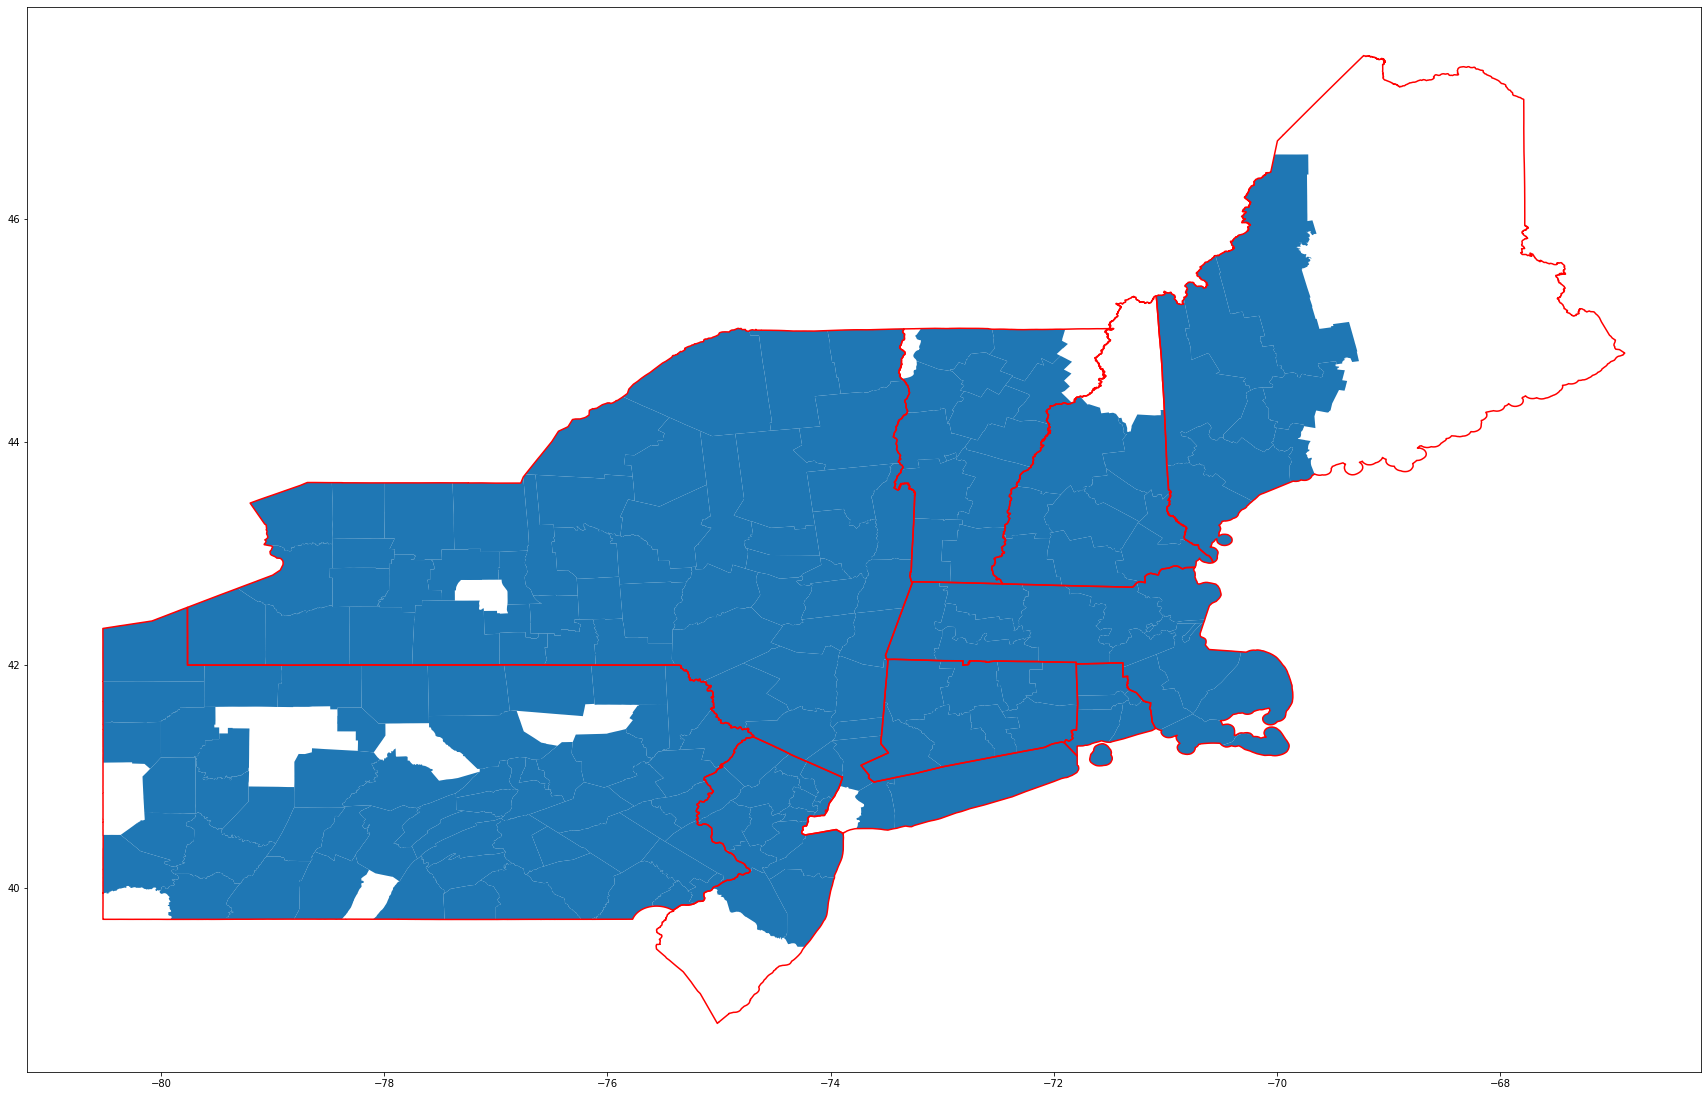

In [39]:
fig,ax = plt.subplots(figsize=(30,20))
gdf_NYTTimeSeries_NewCases.cx[-80:-70, 40:50].plot(ax=ax)
gdf_USStates.boundary.cx[-80:-70, 40:50].plot(ax=ax,color="red")

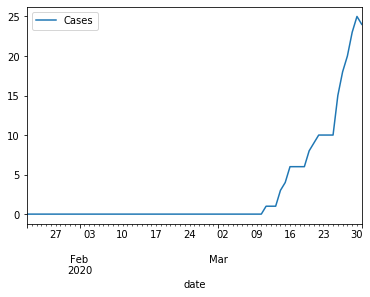

In [40]:
plotCounty(41017,column="Cases",cumulative=True).plot()

Pandas Group By Diff

In [44]:
gdf_countyTimeSeries.head()

,date,county,state,fips,cases,deaths,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019
0,2020-01-21,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
1,2020-01-22,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
2,2020-01-23,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
3,2020-01-24,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
4,2020-01-25,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083


In [54]:
gdf_countyTimeSeries.groupby("fips")[["fips","cases"]].diff().fillna(0)

,fips,cases
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
23596,0.0,0.0
23597,0.0,0.0
23598,0.0,0.0
23599,0.0,0.0


Plot the original dataset

In [56]:
gdf_countyTimeSeriesDiff = gdf_countyTimeSeries.copy(deep=True)

In [57]:
gdf_countyTimeSeriesDiff["new cases"] = gdf_countyTimeSeriesDiff.groupby("fips")[["cases"]].diff().fillna(0)

In [67]:
dt.date(month=4,day=2,year=2020)

datetime.date(2020, 4, 2)

In [68]:
gdf_countyTimeSeriesDiff["date"].head()

0   2020-01-21
1   2020-01-22
2   2020-01-23
3   2020-01-24
4   2020-01-25
Name: date, dtype: datetime64[ns]

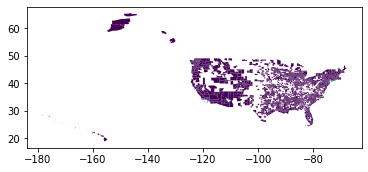

In [74]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["date"] == dt.datetime(month=3,day=27,year=2020)].plot("new cases")

In [99]:
def filterByDate(gdf,dateColumn="date",month=3,day=27,year=2020,operator="="):
    filterDate = dt.datetime(month=month,day=day,year=year)
    if operator == "=":
        gdf = gdf[gdf[dateColumn] == filterDate]
    elif operator == "<":
        gdf = gdf[gdf[dateColumn] < filterDate]
    elif operator == "<=":
            gdf = gdf[gdf[dateColumn] <= filterDate]
    elif operator == ">":
            gdf = gdf[gdf[dateColumn] > filterDate]
    elif operator == ">=":
            gdf = gdf[gdf[dateColumn] >= filterDate]
    else:
        raise(Exception("error, operator not recognized"))
    return gdf

In [100]:
def plotController(month=3,day=1,year=2020):
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    filterByDate(gdf_countyTimeSeries,year=year,month=month,day=day).cx[-125:-50, 20:70].plot("cases",ax=ax,cax=cax,legend="True")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
    ax.set_title(f"Number of confirmed COVID-19 Cases, {month}-{day}-{year}")

In [101]:
interact(plotController,
         month=widgets.IntSlider(min=1,max=12,step=1,value=3),
         day=widgets.IntSlider(min=1,max=31,step=1,value=27),
         year=widgets.IntSlider(min=2019,max=2021,step=1,value=2020),
        )

interactive(children=(IntSlider(value=3, description='month', max=12, min=1), IntSlider(value=27, description=…

<function __main__.plotController(month=3, day=1, year=2020)>

## Load the JHU Data

In [75]:
dailyUpdates = os.listdir(folderOfJHUData)

In [76]:
dailyUpdatesDict = {}
for file in dailyUpdates:
    if ".csv" in file:
        dailyUpdatesDict[dt.datetime.strptime(file.split('.')[0],"%m-%d-%Y")] = file

Now let's use the JHU data to generate a dataframe for counties of: FIPS, County Name, Date1 Confirmed, Date1 Deaths, Date1 Recovered

In [77]:
errorPrint = False
gdf_JHUData = gdf_USCounties.copy(deep=True)
for dti,filename in dailyUpdatesDict.items():
    columnNameBase = dti.strftime("%Y-%m-%d")
    filePath = f"{folderOfJHUData}{filename}"
    df_daily = pd.read_csv(filePath)
    if "FIPS" in df_daily.columns:
        df_daily = df_daily.dropna(subset=["FIPS"])
        df_daily = df_daily[["FIPS","Confirmed","Deaths","Recovered"]]
        df_daily = df_daily.dropna(subset=["FIPS"])
        df_daily["FIPS"] = df_daily["FIPS"].astype("int")
        df_daily.columns = ["FIPS",f"{columnNameBase} Confirmed",f"{columnNameBase} Deaths",f"{columnNameBase} Recovered"]
        gdf_JHUData = pd.merge(left=gdf_JHUData,right=df_daily,left_on="GEOID",right_on="FIPS")
    elif errorPrint:
        print(f"could not process {filename}")

In [80]:
gdf_JHUData.sort_values("2020-04-06 Deaths",ascending=False)

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019,FIPS_x,2020-03-22 Confirmed,2020-03-22 Deaths,2020-03-22 Recovered,FIPS_y,2020-03-23 Confirmed,2020-03-23 Deaths,2020-03-23 Recovered,FIPS_x,2020-03-24 Confirmed,2020-03-24 Deaths,2020-03-24 Recovered,FIPS_y,2020-03-25 Confirmed,2020-03-25 Deaths,2020-03-25 Recovered,FIPS_x,2020-03-26 Confirmed,2020-03-26 Deaths,2020-03-26 Recovered,FIPS_y,2020-03-27 Confirmed,2020-03-27 Deaths,2020-03-27 Recovered,FIPS_x,2020-03-28 Confirmed,2020-03-28 Deaths,2020-03-28 Recovered,FIPS_y,2020-03-29 Confirmed,2020-03-29 Deaths,2020-03-29 Recovered,FIPS_x,2020-03-30 Confirmed,2020-03-30 Deaths,2020-03-30 Recovered,FIPS_y,2020-03-31 Confirmed,2020-03-31 Deaths,2020-03-31 Recovered,FIPS_x,2020-04-01 Confirmed,2020-04-01 Deaths,2020-04-01 Recovered,FIPS_y,2020-04-02 Confirmed,2020-04-02 Deaths,2020-04-02 Recovered,FIPS_x,2020-04-03 Confirmed,2020-04-03 Deaths,2020-04-03 Recovered,FIPS_y,2020-04-04 Confirmed,2020-04-04 Deaths,2020-04-04 Recovered,FIPS_x,2020-04-05 Confirmed,2020-04-05 Deaths,2020-04-05 Recovered,FIPS_y,2020-04-06 Confirmed,2020-04-06 Deaths,2020-04-06 Recovered
1634,36,061,36061,New York,New York County,"MULTIPOLYGON (((-74.04713 40.69054, -74.04710 ...",1628706,36061,9654,63,0,36061,12305,99,0,36061,14904,131,0,36061,17856,199,0,36061,21873,281,0,36061,25573,366,0,36061,29776,517,0,36061,33768,678,0,36061,37453,790,0,36061,43119,932,0,36061,47439,1139,0,36061,51809,1397,0,36061,57159,1584,0,36061,63306,1905,0,36061,67551,2256,0,36061,72181,3485,0
173,26,163,26163,Wayne,Wayne County,"POLYGON ((-83.28780 42.44268, -83.28764 42.442...",1749343,26163,477,5,0,26163,638,8,0,26163,876,13,0,26163,1122,21,0,26163,1389,26,0,26163,1810,37,0,26163,2316,46,0,26163,2704,56,0,26163,3195,83,0,26163,3735,120,0,26163,4470,146,0,26163,5069,194,0,26163,6096,223,0,26163,6762,252,0,26163,7518,293,0,26163,8270,346,0
1354,53,033,53033,King,King County,"POLYGON ((-122.47069 47.52789, -122.46985 47.5...",2252782,53033,1040,75,0,53033,1170,87,0,53033,1170,87,0,53033,1359,101,0,53033,1577,109,0,53033,1577,109,0,53033,2077,136,0,53033,2159,141,0,53033,2161,144,0,53033,2330,150,0,53033,2330,150,0,53033,2656,175,0,53033,2787,186,0,53033,2898,200,0,53033,3167,208,0,53033,3331,222,0
737,36,119,36119,Westchester,Westchester County,"POLYGON ((-73.90928 41.16439, -73.91168 41.167...",967506,36119,1873,0,0,36119,2894,0,0,36119,3891,1,0,36119,4691,1,0,36119,5944,1,0,36119,7187,1,0,36119,7875,10,0,36119,8519,10,0,36119,9326,10,0,36119,9967,10,0,36119,10683,25,0,36119,11567,64,0,36119,12351,67,0,36119,13081,67,0,36119,13723,67,0,36119,14294,211,0
406,17,031,17031,Cook,Cook County,"POLYGON ((-88.23798 42.06693, -88.23797 42.066...",5150233,17031,805,4,0,17031,922,9,0,17031,1194,9,0,17031,1418,14,0,17031,1418,18,0,17031,2239,20,0,17031,2613,28,0,17031,3445,40,0,17031,3727,44,0,17031,4496,61,0,17031,5152,95,0,17031,5575,107,0,17031,6111,141,0,17031,7439,167,0,17031,8034,186,0,17031,8728,209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,19,137,19137,Montgomery,Montgomery County,"POLYGON ((-95.38472 41.07339, -95.38471 41.074...",9917,19137,0,0,0,19137,0,0,0,19137,0,0,0,19137,0,0,0,19137,0,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0,19137,1,0,0
1042,29,186,29186,Ste. Genevieve,Ste. Genevieve County,"POLYGON ((-90.38108 37.93792, -90.38051 37.938...",17894,29186,0,0,0,29186,0,0,0,29186,0,0,0,29186,0,0,0,29186,0,0,0,29186,0,0,0,29186,0,0,0,29186,0,0,0,29186,0,0,0,29186,2,0,0,29186,3,0,0,29186,3,0,0,29186,3,0,0,29186,6,0,0,29186,6,0,0,29186,6,0,0
1041,48,053,48053,Burnet,Burnet County,"POLYGON ((-98.42855 30.65789, -98.42838 30.658...",48155,48053,1,0,0,48053,1,0,0,48053,1,0,0,48053,1,0,0,48053

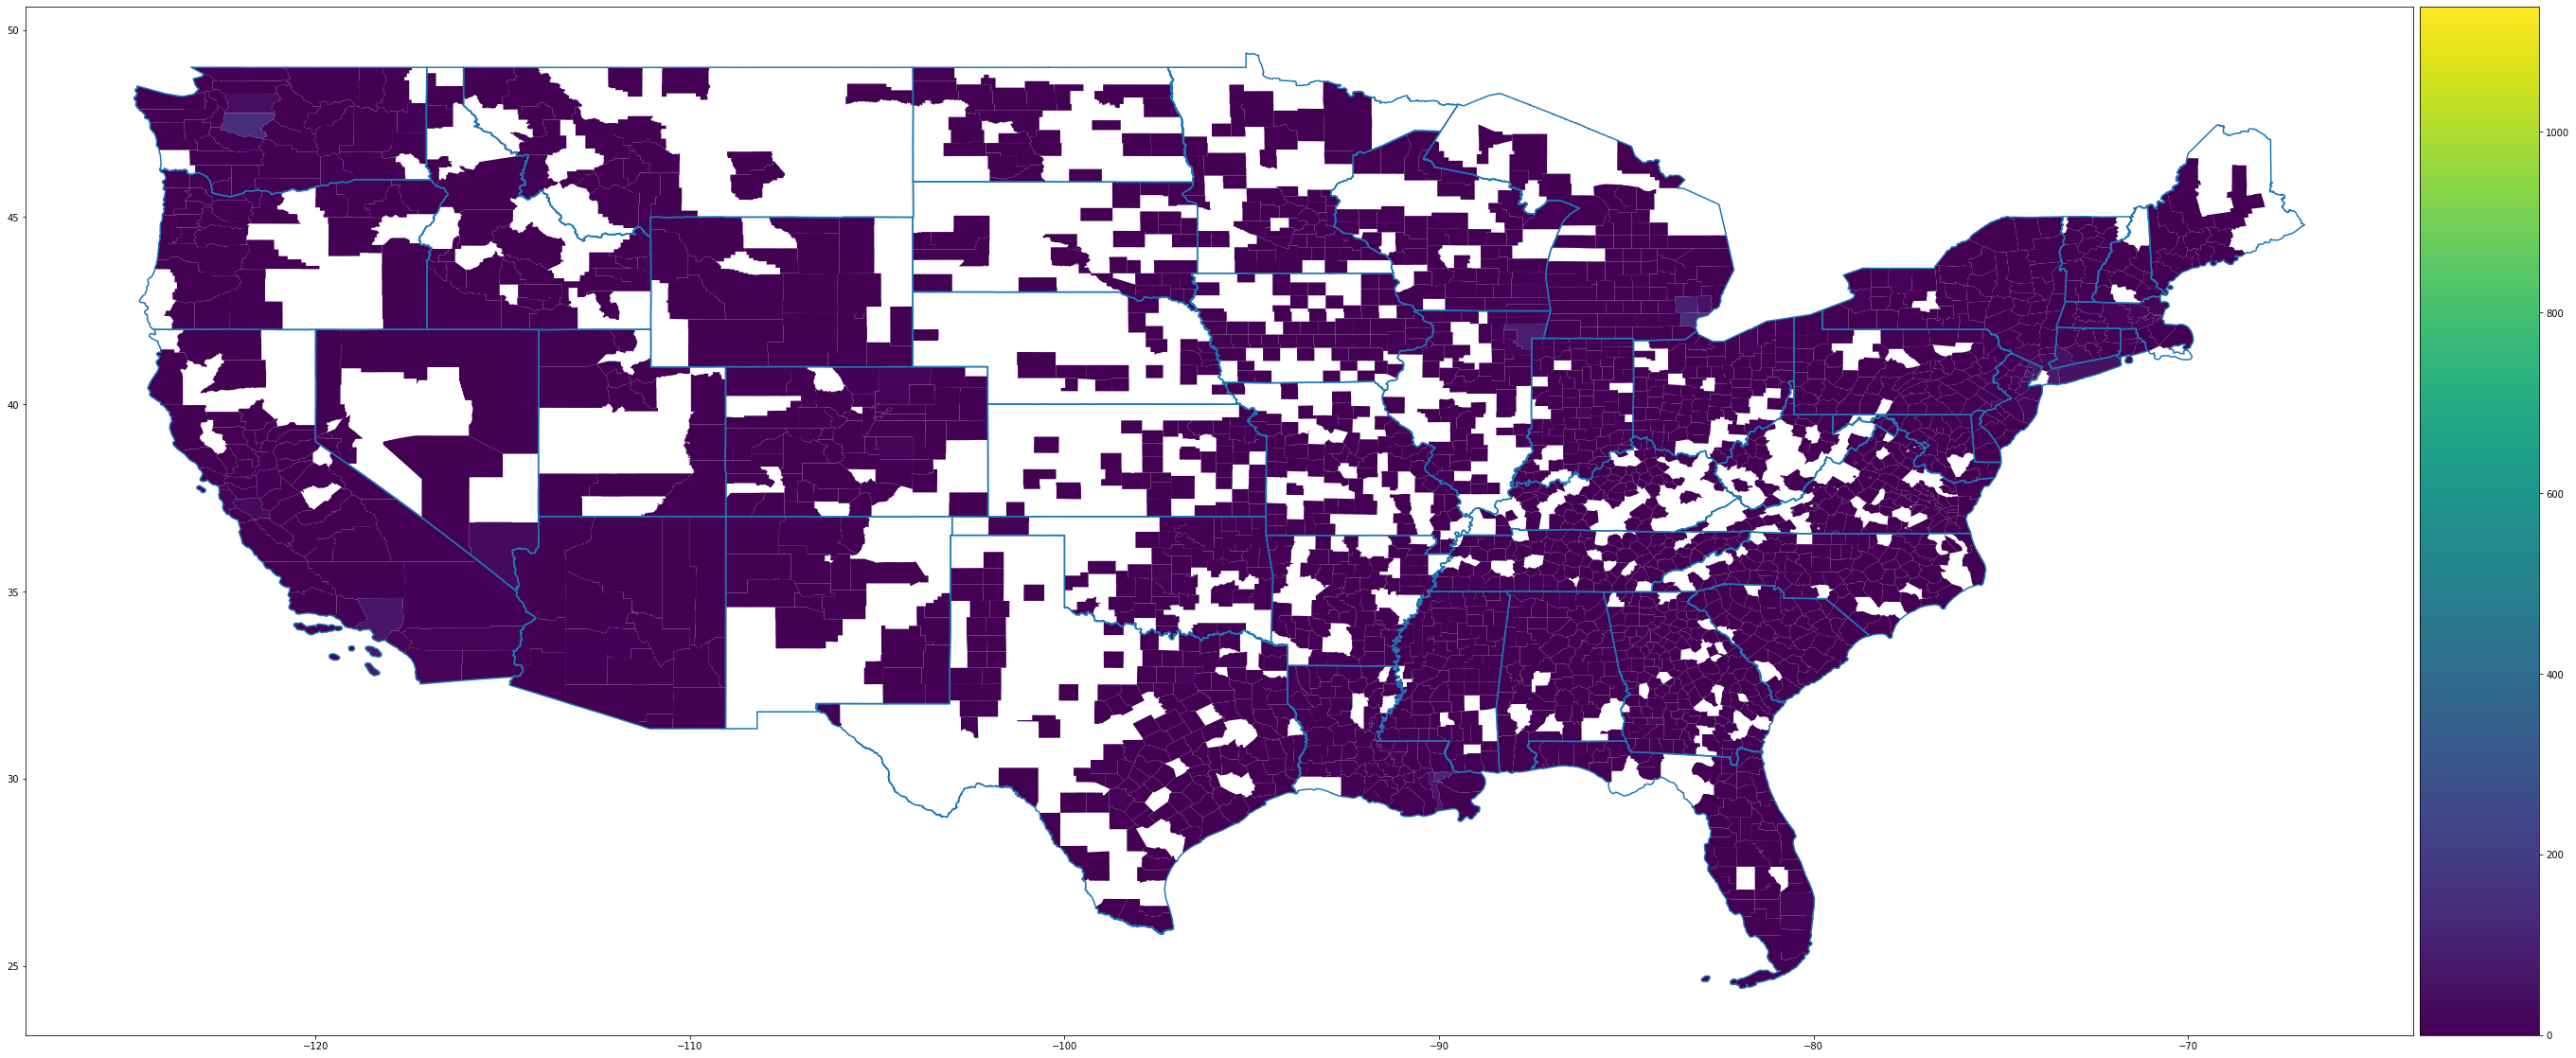

In [81]:
fig,ax = plt.subplots(figsize=(50,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf_JHUData.cx[-125:-50, 20:70].plot("2020-04-01 Deaths",ax=ax,cax=cax,legend="True")
gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)

Try again, but this time restructure like the nyt data and append

In [88]:
errorPrint = False
geoBase = gdf_USCounties.copy(deep=True)
gdf_JHUData_Daily = gdf_USCounties.copy(deep=True)
for dti,filename in dailyUpdatesDict.items():
    columnNameBase = dti.strftime("%Y-%m-%d")
    filePath = f"{folderOfJHUData}{filename}"
    df_daily = pd.read_csv(filePath)
    if "FIPS" in df_daily.columns:
        df_daily = df_daily.dropna(subset=["FIPS"])
        df_daily = df_daily[["FIPS","Confirmed","Deaths","Recovered"]]
        df_daily["date"] = dti
        df_daily["FIPS"] = df_daily["FIPS"].astype("int")
        gdf_JHUData_Daily_Geo = pd.merge(left=geoBase,right=df_daily,left_on="GEOID",right_on="FIPS")
        gdf_JHUData_Daily = pd.concat([gdf_JHUData_Daily,gdf_JHUData_Daily_Geo])
    elif errorPrint:
        print(f"could not process {filename}")

In [92]:
gdf_JHUData_Daily = gdf_JHUData_Daily.dropna(subset=["date"])

In [98]:
gdf_JHUData_Daily[gdf_JHUData_Daily["FIPS"] == 36047]

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019,FIPS,Confirmed,Deaths,Recovered,date
2338,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-22
2338,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-23
2338,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-24
2338,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-25
2337,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-26
2337,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-27
2336,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-28
2336,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-29
2336,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,36047.0,0.0,0.0,0.0,2020-03-30


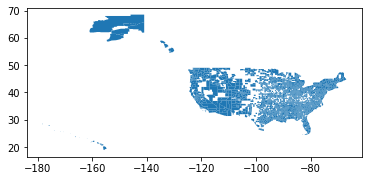

In [91]:
gdf_JHUData_Daily[gdf_JHUData_Daily["date"]==dt.datetime(month=4,day=4,year=2020)].plot()

## Assumptions

In [44]:
rate_fatality = 0.8/100 # https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html
days_to_onset = 5
days_to_hospitalization = 10
days_to_outcome = 24

## Analyses

Estimating cohort risk

- Assume $P_{{infection}}$ is homogenous and homogenous both spatially and across population subsets
- Specify assumed rates for $P_{{{{hospitalization}}_{{age}}}}$ and $P_{{{{death}}_{{age}}}}$
- Specify assumed rates for $P_{{{{absence}}_{{non-illness}}}}$

SIR Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

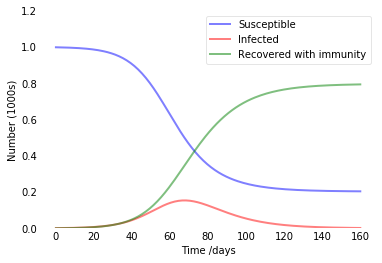

In [45]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

Take a look at https://github.com/Lewuathe/COVID19-SIR

Also take a look at https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296

https://github.com/closedloop-ai/cv19index

https://github.com/CodeForPhilly/chime

https://github.com/coronafighter/coronaSEIR

Playing with SIR models from "Mathematical Epidemiology" page 23

$$S(t+\Delta t) = S(t) - \beta S(t)I(t)\Delta t$$

$$I(t+\Delta t) = I(t) + \beta S(t)I(t)\Delta t - \gamma I(t)\Delta t$$

$$\mathbf{R}_0 = \frac{\beta N}{\gamma}$$

In [46]:
N = 7_781_984 # Population
γ = 0.2 # Recovery rate, meaning that the mean infectious period is 1/γ
R0 = 3 # Basic reproduction number
β = R0 * γ / N # Transmission rate per capita
Δt = 0.1 # Time step for the solution method

In [47]:
I = 1
S = N
Is = [I]
Ss = [S]
ts = np.arange(0,100,Δt)
for t in ts:
    if S < 0:
        S = 0
    if I < 0:
        I = 0
    S_new = S - β * S * I * Δt
    I_new = I + β * S * I * Δt - γ * I * Δt
    S = S_new
    I = I_new
    Ss.append(S)
    Is.append(I)
del Ss[-1] # kludge because for loop is not inclusive
del Is[-1]

Text(0.5, 1.0, 'Simple S.I.R. Model\nγ=0.2,$R_0$=3')

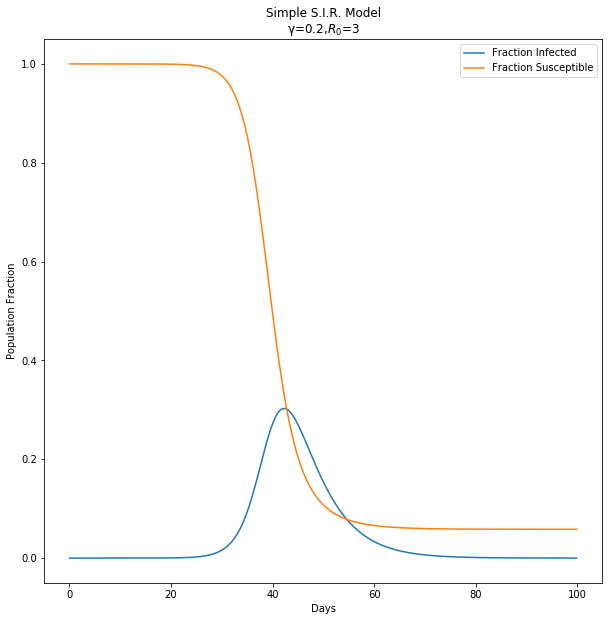

In [48]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(ts,np.array(Is)/N,ax=ax,label="Fraction Infected")
sns.lineplot(ts,np.array(Ss)/N,ax=ax,label="Fraction Susceptible")
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Population Fraction")
ax.set_title(f"Simple S.I.R. Model\nγ={γ},$R_0$={R0}")